In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub

## Existing Data

### Load Data

In [2]:
def get_kaggle_csv(dataset: str, name: str, is_comp: bool = False) -> pd.DataFrame:
    assert name.endswith('.csv')
    if is_comp:
        path = kagglehub.competition_download(dataset)
    else:
        path = kagglehub.dataset_download(dataset)
    return pd.read_csv(os.path.join(path, name))

### PERSUADE Corpus

To get the prompts and source texts for the essays, we will use the PERSUADE corpus.

In [3]:
# https://www.kaggle.com/datasets/nbroad/persaude-corpus-2/
df_prompts = get_kaggle_csv('nbroad/persaude-corpus-2', 'persuade_2.0_human_scores_demo_id_github.csv')
df_prompts = df_prompts[['prompt_name', 'assignment']]
df_prompts.drop_duplicates(inplace=True)
df_prompts.reset_index(drop=True, inplace=True)
df_prompts['prompt_id'] = 'PERSUADE-' + df_prompts['prompt_name'].astype('category').cat.codes.astype(str)

display(df_prompts)

,prompt_name,assignment,prompt_id
0,Phones and driving,Today the majority of humans own and operate c...,PERSUADE-11
1,Car-free cities,Write an explanatory essay to inform fellow ci...,PERSUADE-1
2,Summer projects,Some schools require students to complete summ...,PERSUADE-13
3,"""A Cowboy Who Rode the Waves""","You have just read the article, 'A Cowboy Who ...",PERSUADE-0
4,Mandatory extracurricular activities,Your principal has decided that all students m...,PERSUADE-10
5,Exploring Venus,"In ""The Challenge of Exploring Venus,"" the aut...",PERSUADE-7
6,Facial action coding system,"In the article ""Making Mona Lisa Smile,"" the a...",PERSUADE-8
7,The Face on Mars,You have read the article 'Unmasking the Face ...,PERSUADE-14
8,Community service,Some of your friends perform community service...,PERSUADE-3
9,Grades for extracurricular activities,Your principal is considering changing school ...,PERSUADE-9


In [4]:
df_prompts['assignment'].value_counts()

assignment
Today the majority of humans own and operate cell phones on a daily basis. In essay form, explain if drivers should or should not be able to use cell phones in any capacity while operating a vehicle.                                                                                                                                                                                                                                                                                                                                                                                                                   1
Write an explanatory essay to inform fellow citizens about the advantages of limiting car usage. Your essay must be based on ideas and information that can be found in the passage set. Manage your time carefully so that you can read the passages; plan your response; write your response; and revise and edit your response. Be sure to use evidence from multiple sources; and avoid overl

### Competition Data

In [5]:
df_comp_train = get_kaggle_csv('llm-detect-ai-generated-text', 'train_essays.csv', is_comp=True)
# df_test = get_kaggle_csv('llm-detect-ai-generated-text', 'test_essays.csv', is_comp=True)

# still need to keep this, in case the index is different from that of `df_perusade`
df_comp_prompts = get_kaggle_csv('llm-detect-ai-generated-text', 'train_prompts.csv', is_comp=True)

In [6]:
df_comp_train['prompt_name'] = df_comp_train['prompt_id'].map(df_comp_prompts.set_index('prompt_id')['prompt_name'])
df_comp_train['prompt_id'] = df_comp_train['prompt_name'].map(df_prompts.set_index('prompt_name')['prompt_id'])
df_comp_train.drop(columns=['prompt_name', 'id'], inplace=True)
df_comp_train['source'] = df_comp_train['generated'].apply(lambda x: 'unknown' if x else 'human')

# Just process test data in the submission notebook
# df_test['prompt_name'] = df_test['prompt_id'].map(df_train_prompts.set_index('prompt_id')['prompt_name'])
# df_test['prompt_id'] = df_test['prompt_name'].map(df_persuade.set_index('prompt_name')['prompt_id'])
# df_test.drop(columns=['prompt_name', 'id'], inplace=True)

,prompt_id,text,generated,source
0,PERSUADE-1,Cars. Cars have been around since they became ...,0,human
1,PERSUADE-1,Transportation is a large necessity in most co...,0,human
2,PERSUADE-1,"""America's love affair with it's vehicles seem...",0,human
3,PERSUADE-1,How often do you ride in a car? Do you drive a...,0,human
4,PERSUADE-1,Cars are a wonderful thing. They are perhaps o...,0,human
...,...,...,...,...
1373,PERSUADE-5,There has been a fuss about the Elector Colleg...,0,human
1374,PERSUADE-1,Limiting car usage has many advantages. Such a...,0,human
1375,PERSUADE-1,There's a new trend that has been developing f...,0,human
1376,PERSUADE-1,As we all know cars are a big part of our soci...,0,human


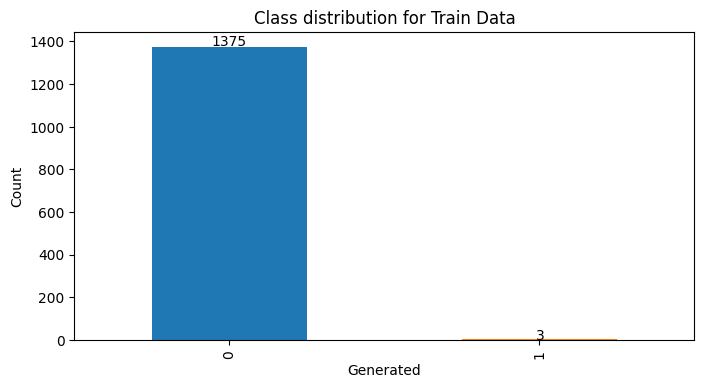

In [7]:
display(df_comp_train)

# Show distribution of answers using bar plot
plt.figure(figsize=(8, 4))
ax = df_comp_train.generated.value_counts().plot.bar(
    color=['tab:blue', 'tab:orange'])
for p in ax.patches:
    ax.annotate(
        str(p.get_height()),
        (p.get_x() * 1.005 + p.get_width() / 2.0, p.get_height() * 1.005),
        ha='center')
plt.xlabel('Generated')
plt.ylabel('Count')
plt.title('Class distribution for Train Data')
plt.show()

### External Data

In [8]:
ext_dfs = []

In [9]:
# https://www.kaggle.com/datasets/thedrcat/daigt-v4-train-dataset
# Dedicated dataset for the competition
df_ext = get_kaggle_csv('thedrcat/daigt-v4-train-dataset', 'train_v4_drcat_01.csv')

df_ext['prompt_id'] = df_ext['prompt_name'].map(df_prompts.set_index('prompt_name')['prompt_id'])
df_ext.drop(columns=['source'], inplace=True)  # prevent duplicate columns
df_ext.rename(columns={'label': 'generated', 'model': 'source'}, inplace=True)
df_ext = df_ext[['prompt_id', 'text', 'generated', 'source']]

display(df_ext)
ext_dfs.append(df_ext)

,prompt_id,text,generated,source
0,PERSUADE-11,Phones\n\nModern humans today are always on th...,0,human
1,PERSUADE-11,This essay will explain if drivers should or s...,0,human
2,PERSUADE-11,Driving while the use of cellular devices\n\nT...,0,human
3,PERSUADE-11,Phones & Driving\n\nDrivers should not be able...,0,human
4,PERSUADE-11,Cell Phone Operation While Driving\n\nThe abil...,0,human
...,...,...,...,...
73568,PERSUADE-9,I am writing you today to disagree with your t...,1,llama
73569,PERSUADE-9,"Dear Principal,\n\nIn conclusion, I would obse...",1,llama
73570,PERSUADE-9,"Dear Mrs. Principal,\n\nin these kinds of cons...",1,llama
73571,PERSUADE-9,I enjoyed Form five and excitedly ex claims ed...,1,llama


In [10]:
# https://www.kaggle.com/datasets/alejopaullier/argugpt
# ArguGPT is a dataset of argumentative essays generated by various models. i.e. all the essays are generated.
df_ext = get_kaggle_csv('alejopaullier/argugpt', 'argugpt.csv')

assert len(set(df_ext.prompt.unique()) & set(df_prompts.assignment.unique())) == 0 # should be no prompt from PERUSADE

df_ext.rename(columns={'prompt': 'assignment'}, inplace=True)
df_prompts = pd.concat([df_prompts, df_ext[['prompt_id', 'assignment']].drop_duplicates()], ignore_index=True)
df_ext['generated'] = 1
df_ext.rename(columns={'model': 'source'}, inplace=True)
df_ext = df_ext[['prompt_id', 'text', 'generated', 'source']]

display(df_ext)
ext_dfs.append(df_ext)

,prompt_id,text,generated,source
0,WECCL-17,There are many people who think that universit...,1,text-babbage-001
1,WECCL-17,There are a number of reasons why people might...,1,text-babbage-001
2,WECCL-17,There are many reasons why university educatio...,1,text-babbage-001
3,WECCL-17,There are many people who think that universit...,1,text-babbage-001
4,WECCL-17,There is a general consensus that university e...,1,text-babbage-001
...,...,...,...,...
4033,GRE-603,The notion that one must be forced to defend a...,1,text-davinci-003
4034,GRE-604,I strongly agree with the statement that menta...,1,gpt-3.5-turbo
4035,GRE-660,"In today’s world, where competition is highly ...",1,gpt-3.5-turbo
4036,GRE-671,Education is one of the most powerful tools th...,1,gpt-3.5-turbo


In [11]:
# https://www.kaggle.com/datasets/conjuring92/fpe-processed-dataset
# Synthetic dataset from T5, based on PERSUADE (?)
df_ext = get_kaggle_csv('conjuring92/fpe-processed-dataset', 'mlm_essays_processed.csv')

df_ext.rename(columns={'essay_text': 'text'}, inplace=True)
df_ext['generated'] = 1
df_ext['source'] = 'T5'

# need to use hand-crafted prompt names to match with above datasets
_map_prompt2name = {
    'Should the electoral college be abolished in favor of popular vote?': 'Does the electoral college work?',
    'Is distance learning or online schooling beneficial to students?': 'Distance learning',
    'Should you ask multiple people for advice?': 'Seeking multiple opinions',
    'Are driverless cars going to be helpful?': 'Driverless cars',
    'Should computers read the emotional expressions of students in a classroom?': 'Facial action coding system',
    'Is Studying Venus a worthy pursuit?': 'Exploring Venus',
    'Should car usage be limited to help reduce pollution?': 'Car-free cities',
    'Is the face on Mars  a natural landform or made by Aliens?': 'The Face on Mars',  # [sic]
    'Should school summer projects be designed by students or teachers?': 'Summer projects',
    'Should community service be mandatory for all students?': 'Community service',
    'Should students be allowed to use cell phones in school?': 'Cell phones at school',
    'Should all students participate in at least one extracurricular activity?': 'Mandatory extracurricular activities',
    'Should students be allowed to participate in sports  unless they have at least a grade B average?': 'Grades for extracurricular activities',
    'Should you join the Seagoing Cowboys program?': '"A Cowboy Who Rode the Waves"',
    'Should drivers be allowed to use cell phones while driving?': 'Phones and driving',
}
_map_prompt2id = {p: df_prompts.set_index('prompt_name')['prompt_id'][n] for p, n in _map_prompt2name.items()}
df_ext['prompt_id'] = df_ext['prompt'].map(lambda p: _map_prompt2id[p])
df_ext = df_ext[['prompt_id', 'text', 'generated', 'source']]

display(df_ext)
ext_dfs.append(df_ext)

,prompt_id,text,generated,source
0,PERSUADE-8,"In my opinion, I do not think the use of a tec...",1,T5
1,PERSUADE-5,"Dear senator,\n\nI belive that changing the el...",1,T5
2,PERSUADE-7,The author of the article is telling us that V...,1,T5
3,PERSUADE-5,"Dear Senator,\n\nThe Electoral College has cau...",1,T5
4,PERSUADE-5,"Dear Senator,\n\nI believe that the Electoral ...",1,T5
...,...,...,...,...
35757,PERSUADE-12,Do you ever want more opinions and options whe...,1,T5
35758,PERSUADE-12,Has anyone ever gave you advice? Was the advic...,1,T5
35759,PERSUADE-12,Imagine seeking advice from multiple people an...,1,T5
35760,PERSUADE-12,There has been at least one point in everyone'...,1,T5


## Combine & Clean Data

In [12]:
df = pd.concat([
    df_comp_train,
    *ext_dfs
], ignore_index=True)

In [13]:
# remove duplicates between datasets
df.drop_duplicates(('text'), inplace=True, keep='last')

In [14]:
# mislabeling in DAIGT v4
# df.loc[df['source'] == 'human', df['generated'] == 1].source = 'unknown'
df.source = np.where((df['source'] == 'human') & (df['generated'] == 1), 'unknown', df['source'])

In [15]:
_source_map = {
    'text-babbage-001': 'babbage',
    'text-curie-001': 'curie',
    'text-davinci-001': 'davinci',
    'text-davinci-002': 'davinci',
    'text-davinci-003': 'davinci',
    'gpt2-xl': 'gpt',
    'gpt-3.5-turbo': 'gpt',
}
df['source'] = df['source'].map(_source_map).fillna(df['source'])

_source_map_simple = {
    'ada': 'gpt',
    'babbage': 'gpt',
    'curie': 'gpt',
    'davinci': 'gpt',
}
df['source'] = df['source'].map(_source_map_simple).fillna(df['source'])

## Visualize Data

,prompt_id,text,generated,source
1378,PERSUADE-11,Phones\n\nModern humans today are always on th...,0,human
1379,PERSUADE-11,This essay will explain if drivers should or s...,0,human
1380,PERSUADE-11,Driving while the use of cellular devices\n\nT...,0,human
1383,PERSUADE-11,Cell phone use should not be legal while drivi...,0,human
1384,PERSUADE-11,Phones and Driving\n\nDriving is a good way to...,0,human
...,...,...,...,...
114746,PERSUADE-12,Do you ever want more opinions and options whe...,1,T5
114747,PERSUADE-12,Has anyone ever gave you advice? Was the advic...,1,T5
114748,PERSUADE-12,Imagine seeking advice from multiple people an...,1,T5
114749,PERSUADE-12,There has been at least one point in everyone'...,1,T5


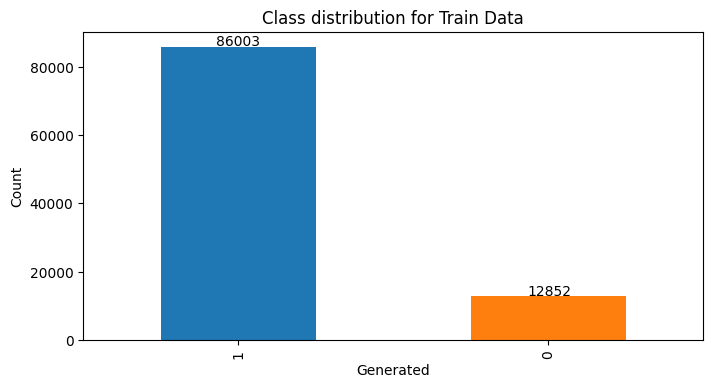

In [16]:
display(df)

# Show distribution of answers using bar plot
plt.figure(figsize=(8, 4))
ax = df.generated.value_counts().plot.bar(
    color=['tab:blue', 'tab:orange'])
for p in ax.patches:
    ax.annotate(
        str(p.get_height()),
        (p.get_x() * 1.005 + p.get_width() / 2.0, p.get_height() * 1.005),
        ha='center')
plt.xlabel('Generated')
plt.ylabel('Count')
plt.title('Class distribution for Train Data')
plt.show()

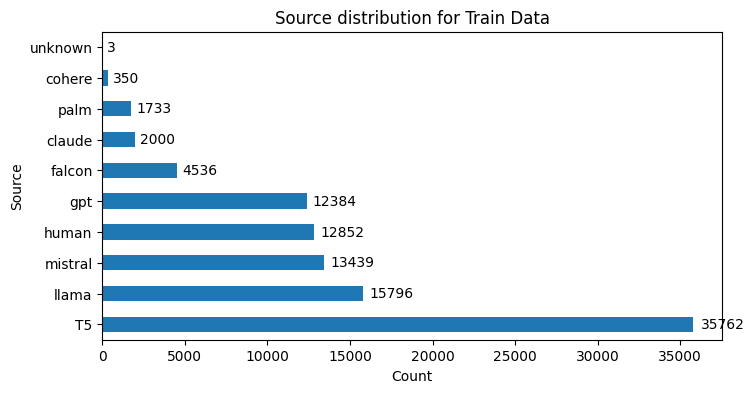

In [17]:
plt.figure(figsize=(8, 4))
ax = df.source.value_counts().plot.barh()
for p in ax.patches:
    ax.annotate(
        str(p.get_width()),
        (p.get_width() * 1.005 + 300, p.get_y() + p.get_height() / 2.0),
        va='center')
plt.xlabel('Count')
plt.ylabel('Source')
plt.title('Source distribution for Train Data')
plt.show()

In [18]:
df_prompts = df_prompts[['prompt_id', 'assignment']].drop_duplicates()
display(df_prompts)

,prompt_id,assignment
0,PERSUADE-11,Today the majority of humans own and operate c...
1,PERSUADE-1,Write an explanatory essay to inform fellow ci...
2,PERSUADE-13,Some schools require students to complete summ...
3,PERSUADE-0,"You have just read the article, 'A Cowboy Who ..."
4,PERSUADE-10,Your principal has decided that all students m...
...,...,...
633,GRE-603,Only by being forced to defend an idea against...
634,GRE-604,Students should be encouraged to realize that ...
635,GRE-660,The best preparation for life or a career is n...
636,GRE-671,AII nations should help support the developmen...


## Save Data

In [19]:
df.to_csv('train_essays.csv', index=False)
df_prompts.to_csv('train_prompts.csv', index=False)

## Citation
Jules King, Perpetual Baffour, Scott Crossley, Ryan Holbrook, and Maggie Demkin. LLM - Detect AI Generated Text. https://kaggle.com/competitions/llm-detect-ai-generated-text, 2023. Kaggle.